Full name: Behzad Yousefipour

Student num: 401300033

In [48]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image as im
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader

In [49]:
# Data loading:

traindata = pd.read_csv("Q3_train.csv")
testdata = pd.read_csv("Q3_test.csv")

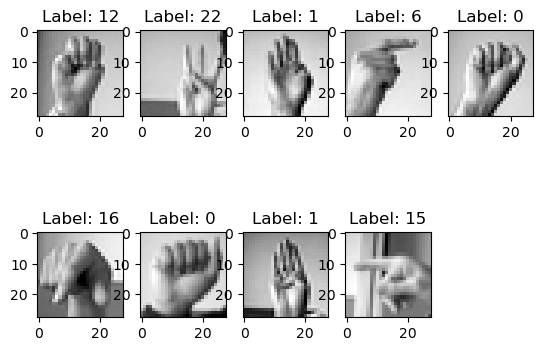

In [50]:
# Data image show:

n = 1
for i in range(9):
    
    location = random.randint(0,len(traindata))
    array = np.array(traindata.loc[location])
    label = array[0]
    array = np.reshape(array[1:], (28, 28))   
    array = np.uint8(array)
    plt.subplot(2, 5, n)
    plt.title("Label: "+str(label))
    plt.imshow(im.fromarray(array),cmap='gray')
    n += 1

plt.show()

In [51]:
# Train, Validation. and test data spliting:

train = np.array(traindata.drop(columns = 'label'))
tr_l = np.array(traindata.iloc[:,[0]])

X_train, X_val, y_train, y_val = train_test_split(train, tr_l, test_size=0.25
                                                    ,shuffle=True)

X_test = np.array(testdata.drop(columns = 'label'))
y_test = np.array(testdata.iloc[:,[0]])

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
y_val = torch.from_numpy(y_val)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
X_val = torch.from_numpy(X_val)

class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

traindata = MyDataset(X_train, y_train)
testdata =  MyDataset(X_test, y_test)
valdata =  MyDataset(X_val, y_val)

train_dataloader = DataLoader(traindata, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testdata, batch_size=64, shuffle=True)
val_dataloader = DataLoader(valdata, batch_size=64, shuffle=True)

In [52]:
# Neural Network structure:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 25),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=25, bias=True)
  )
)


In [53]:
# Hyper params:

learning_rate = 1e-4
batch_size = 64

In [54]:
# NN optimization:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):      
        # Compute prediction and loss
        # X, y = X.to(device), y.to(device)
        pred = model(X.to(torch.float32))
        loss = loss_fn(pred, y.squeeze().to(torch.int64))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32))
            test_loss += loss_fn(pred, y.squeeze().to(torch.int64)).item()
            correct += (pred.argmax(1) == y.squeeze()).type(torch.int64).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [55]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# ADAM optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 20.381054  [    0/20591]
loss: 1.887966  [ 6400/20591]
loss: 1.312777  [12800/20591]
loss: 0.886673  [19200/20591]
Test Error: 
 Accuracy: 67.2%, Avg loss: 1.012161 

Epoch 2
-------------------------------
loss: 0.866098  [    0/20591]
loss: 0.639659  [ 6400/20591]
loss: 0.736126  [12800/20591]
loss: 0.371516  [19200/20591]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.392947 

Epoch 3
-------------------------------
loss: 0.438612  [    0/20591]
loss: 0.370661  [ 6400/20591]
loss: 0.269096  [12800/20591]
loss: 0.178814  [19200/20591]
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.158518 

Epoch 4
-------------------------------
loss: 0.240300  [    0/20591]
loss: 0.185345  [ 6400/20591]
loss: 0.119993  [12800/20591]
loss: 0.071954  [19200/20591]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.088294 

Epoch 5
-------------------------------
loss: 0.076140  [    0/20591]
loss: 0.043675  [ 6400/20591]
loss: 0.107152  [12800/20591]
loss: 0.026403  [1920

In [56]:
# Model testing:

test_loop(val_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003281 



In [61]:
# Neural Network structure again, for weight initialization:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 25),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=25, bias=True)
  )
)


In [62]:
# SGD optimizer:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
learning_rate = 2*1e-3

# Training and validation:

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 8.732738  [    0/20591]
loss: 2.959907  [ 6400/20591]
loss: 2.261706  [12800/20591]
loss: 2.145778  [19200/20591]
Test Error: 
 Accuracy: 29.9%, Avg loss: 2.247975 

Epoch 2
-------------------------------
loss: 2.078743  [    0/20591]
loss: 1.852700  [ 6400/20591]
loss: 1.575782  [12800/20591]
loss: 1.491706  [19200/20591]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.378207 

Epoch 3
-------------------------------
loss: 1.153053  [    0/20591]
loss: 1.697501  [ 6400/20591]
loss: 1.092401  [12800/20591]
loss: 0.703674  [19200/20591]
Test Error: 
 Accuracy: 63.2%, Avg loss: 1.077906 

Epoch 4
-------------------------------
loss: 1.093609  [    0/20591]
loss: 0.852950  [ 6400/20591]
loss: 0.751620  [12800/20591]
loss: 0.956427  [19200/20591]
Test Error: 
 Accuracy: 66.5%, Avg loss: 1.051782 

Epoch 5
-------------------------------
loss: 0.939888  [    0/20591]
loss: 0.512242  [ 6400/20591]
loss: 0.641775  [12800/20591]
loss: 0.517321  [19200

In [63]:
# Model testing:

test_loop(val_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 99.7%, Avg loss: 0.041149 



Note: The Adam algorithm contains the SGD algorithm. The difference between these two algorithms is the presence of an adaptive learning rate in the Adam algorithm, which acts as a regulator

In [68]:
# Neural Network structure again, with dropout layer:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 25),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=25, bias=True)
  )
)


In [69]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
# ADAM optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 14.048424  [    0/20591]
loss: 2.430045  [ 6400/20591]
loss: 1.836331  [12800/20591]
loss: 1.485240  [19200/20591]
Test Error: 
 Accuracy: 52.5%, Avg loss: 1.500015 

Epoch 2
-------------------------------
loss: 1.678792  [    0/20591]
loss: 1.215633  [ 6400/20591]
loss: 1.338280  [12800/20591]
loss: 0.799167  [19200/20591]
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.829084 

Epoch 3
-------------------------------
loss: 0.687710  [    0/20591]
loss: 0.588306  [ 6400/20591]
loss: 0.438040  [12800/20591]
loss: 0.570971  [19200/20591]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.560143 

Epoch 4
-------------------------------
loss: 0.591869  [    0/20591]
loss: 0.489020  [ 6400/20591]
loss: 0.288813  [12800/20591]
loss: 0.296048  [19200/20591]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.360591 

Epoch 5
-------------------------------
loss: 0.412972  [    0/20591]
loss: 0.438727  [ 6400/20591]
loss: 0.216658  [12800/20591]
loss: 0.285658  [1920

In [70]:
# Model testing with dropout:

test_loop(val_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.132820 



Note: Dropout layer is a regulator that improves the model predict rate on testing data. in fact, with dropout layer we handle the overfitting problem of the model in the training phase